In [8]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import pandas as pd
from datetime import datetime
import csv

class Struct:
    pass

## Define classe que tem as funções do VNS (MyVNS)

In [3]:
class MyVNS:
    # o objetivo do shake é escolher uma solução aleatoria da k-esima estrutura de vizinhança
    def shake(self, x, k, probdata):
        y = copy.deepcopy(x)

        ridx1 = np.random.randint(0, probdata.n)
        ridx2 = np.random.randint(0, probdata.n)

        blockSize=50
        startIndex = np.random.randint(0, probdata.n - blockSize)
        blockIndices = range(startIndex, startIndex + blockSize)
        
        if k == 1:             # troca o plano por um diferente movimento 1-swap
            y.solution[ridx1] = np.random.choice([j for j in [0, 1, 2] if j != x.solution[ridx1]])
        elif k == 2:           # permutaçao de dois planos de manutenção em dois equipamentos diferentes
            y.solution[ridx1], y.solution[ridx2] = x.solution[ridx2], x.solution[ridx1]
        elif k == 3:           # Mudança de um bloco de equipamentos para outro plano (sair de mínimo local)
            # Pega o plano mais comum no bloco e muda para outro
            currentPlans = [x.solution[i] for i in blockIndices]
            currentPlan = max(set(currentPlans), key=currentPlans.count,)
            newPlan = np.random.choice([j for j in [0, 1, 2] if j != currentPlan])
            
            for i in blockIndices:
                y.solution[i] = newPlan

        return y

    # toma a decisao de mudar de vizinhança, comparando a solução imcubente x com a solução do shake y
    def neighborhoodChange(self, x, y, k):
        if y.fitness < x.fitness:
            x = copy.deepcopy(y)
            k = 1
        else:
            k += 1
            
        return x, k
        
    
    # retorna a primeira melhor solução que achar na estrutura de vizinhança local à solução x
    def firstImprovement(self,w1,w2, x, probdata, fobj, k):
        neighborhood_size = 100

        for j in range(neighborhood_size):
            current_solution = self.shake(x, k, probdata)
            
            if fobj(w1,w2,current_solution, probdata).fitness < fobj(w1,w2,x, probdata).fitness:
                return current_solution

        # se nao achou ninguem melhor, retorna a solução original mesmo mesmo
        return x    
    
    # retorna a melhor solução que achar na estrutura de vizinhança local à solução x
    def bestImprovement(self,w1,w2, x, probdata, fobj, k):
        neighborhood_size = 100
        best_solution = copy.deepcopy(x)

        for j in range(neighborhood_size):
            current_solution = self.shake(x, k, probdata)
            
            if fobj(w1,w2,current_solution, probdata).fitness < fobj(w1,w2,best_solution, probdata).fitness:
                best_solution = current_solution

        return best_solution   

## Define classe que tem a definição do problema (MyProblem)

In [4]:
class MyProblem:
    '''  
    Modelamos a solução x como a sequência de manutenções atribuídas em um vetor. exemplo
    
        eq1 eq2 ... eq500
    x = [2   0  ...   1]

        nesse exemplo, o equipamento eq1 executa a manutenção que tem custo 2, o equipamento eq2 manutenção que tem custo 0, ...
    '''
            
    def fobj1(self, x, probdata):
        # x.solution é um vetor com os custos de manutenção da i-esima maquina (0, 1 ou 2)
        # é só somar o vetor que temos a solução
        fitness = np.sum(x.solution)

        return fitness
    
    def fobj2(self, x, probdata):
        # x.solution é um vetor com os custos de manutenção da i-esima maquina, também é o indice j de dipij
        # é só somar o os valores de dipij variando o valor de j
        fitness=0
        for i in range(0,probdata.n):
            j=x.solution[i]
            fitness = fitness + probdata.dipij[i,j]
        
        return fitness
    
    def soma_ponderada(self,w1,w2,x,probdata):
        min_f1 = 0
        max_f1 = 1000
        min_f2 = 1048.17 
        max_f2 = 1745.49

        f1 = self.fobj1(x, probdata)
        f2 = self.fobj2(x, probdata)
        
        x.f1=f1
        x.f2=f2
        
        x.f1norm=((f1 - min_f1) / (max_f1 - min_f1))
        x.f2norm=((f2 - min_f2) / (max_f2 - min_f2))
        x.fitness=w1*x.f1norm + w2*x.f2norm
        
        return x


    def sol_inicial(self, probdata, apply_constructive_heuristic):
        if apply_constructive_heuristic == False:        
            # Constrói solução inicial aleatoriamente
            x = Struct()
            x.solution = np.random.randint(0, 2 + 1, size=(probdata.n))
        
        else:
            # Constrói solução inicial usando uma heurística construtiva
            x = Struct()
            x.solution = np.random.randint(0, 2 + 1, size=(probdata.n))
            for i in range(probdata.n):        
                var = np.var(probdata.dipij[i,:]) 
                if var>0.5: #limiar da variância
                    x.solution[i]=2
                else:
                    x.solution[i]=0
            #print(x.solution)
        return x
    
    def probF(self,eta,beta,t):
        return (1-np.exp(-(t/eta)**(beta)))
    
    def probdef(self):
        n = 500 # número de equipamentos

        # extrai os dados do CSV e salva na matriz
        equip_db = np.zeros(shape=(n, 4))

        with open('arquivos_tc/EquipDB.csv', newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')

            for idx, row in enumerate(spamreader):
                row_array = ', '.join(row).split(',')
                data_array = []
                
                for item in row_array:
                    data_array.append(float(item))

                equip_db[idx] = np.array(data_array)

        # agora le o arquivo mpdb
        mpdb = np.zeros(shape=(3, 3))
    	
        # custos do problema sao a ultima coluna do mpdb
        c = np.zeros(3)

        with open('arquivos_tc/MPDB.csv', newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')

            for idx, row in enumerate(spamreader):
                row_array = ', '.join(row).split(',')
                data_array = []
                
                for item in row_array:
                    data_array.append(float(item))

                mpdb[idx] = np.array(data_array)
                c[idx] = data_array[len(data_array) - 1]

        # agora le o arquivo cluster
        cluster = np.zeros(shape=(4, 3))
    	
        with open('arquivos_tc/ClusterDB.csv', newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')

            for idx, row in enumerate(spamreader):
                row_array = ', '.join(row).split(',')
                data_array = []
                
                for item in row_array:
                    data_array.append(float(item))

                cluster[idx] = np.array(data_array)
        
        # geração da matriz dipij, cada linha é um equipamento i e cada coluna o dipij do plano de manutenção j
        dipij = np.zeros(shape=(n, 3))

        for i in range(0,n):
            clusterid=int(equip_db[i,2]-1)
            eta=cluster[clusterid,1]
            beta=cluster[clusterid,2]
            t0=equip_db[i,1]
            di=equip_db[i,3]
            
            for j in range(0,3):
                k=mpdb[j,1]
                Ft0=self.probF(eta,beta,t0)
                Ft0kt=self.probF(eta,beta,(t0+k*5))
                dipij[i,j]= di*(Ft0kt-Ft0)/(1-Ft0)
                # print(f"i={i}  j={j}  k={k}  eta={eta}  beta={beta}  t0={t0}  Ft0={Ft0}  Ft0kt={Ft0kt}  pij={(Ft0kt-Ft0)/(1-Ft0)}")
        
        probdata = Struct()
        probdata.equip_db = equip_db
        probdata.mpdb = mpdb
        probdata.c = c
        probdata.n = n
        probdata.dipij =dipij
            
        return probdata

# Loop principal começa aqui

Rodando execução 1...
Ponto 1...
Ponto 2...
Ponto 3...
Ponto 4...
Ponto 5...
Ponto 6...
Ponto 7...
Ponto 8...
Ponto 9...
Ponto 10...
Ponto 11...
Ponto 12...
Ponto 13...
Ponto 14...
Ponto 15...
Ponto 16...
Ponto 17...
Ponto 18...
Ponto 19...
Ponto 20...
Rodando execução 2...
Ponto 1...
Ponto 2...
Ponto 3...
Ponto 4...
Ponto 5...
Ponto 6...
Ponto 7...
Ponto 8...
Ponto 9...
Ponto 10...
Ponto 11...
Ponto 12...
Ponto 13...
Ponto 14...
Ponto 15...
Ponto 16...
Ponto 17...
Ponto 18...
Ponto 19...
Ponto 20...
Rodando execução 3...
Ponto 1...
Ponto 2...
Ponto 3...
Ponto 4...
Ponto 5...
Ponto 6...
Ponto 7...
Ponto 8...
Ponto 9...
Ponto 10...
Ponto 11...
Ponto 12...
Ponto 13...
Ponto 14...
Ponto 15...
Ponto 16...
Ponto 17...
Ponto 18...
Ponto 19...
Ponto 20...
Rodando execução 4...
Ponto 1...
Ponto 2...
Ponto 3...
Ponto 4...
Ponto 5...
Ponto 6...
Ponto 7...
Ponto 8...
Ponto 9...
Ponto 10...
Ponto 11...
Ponto 12...
Ponto 13...
Ponto 14...
Ponto 15...
Ponto 16...
Ponto 17...
Ponto 18...
Ponto 19...


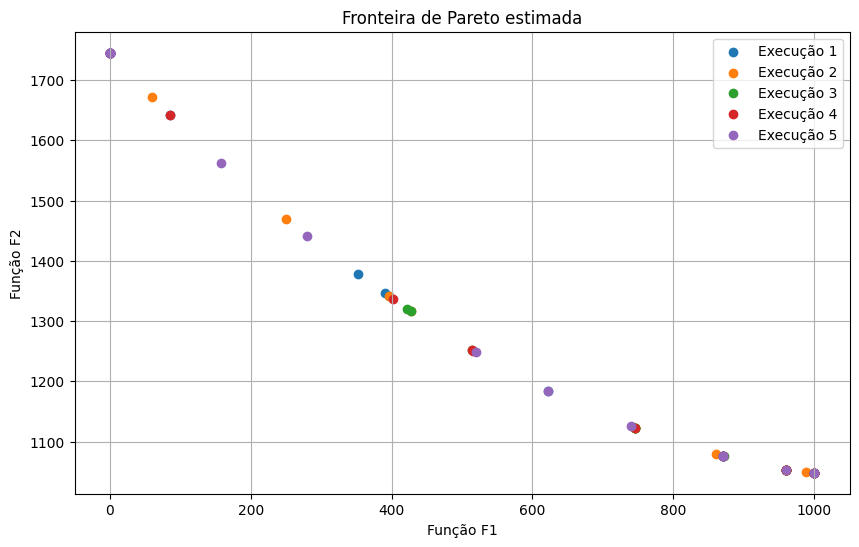


Arquivo salvo: resultados_pareto_somaPonderada_2025-06-01_02-07-02.csv


In [16]:
import matplotlib.pyplot as plt
import numpy as np

num_execucoes = 5
num_pts_fronteira = 20
max_num_sol_avaliadas = 2000
kmax = 3

# Cria instâncias dos objetos
myProblem = MyProblem()
myVNS = MyVNS()

# Gera os dados do problema
probdata = myProblem.probdef()

fronteiraParetof1 = []
fronteiraParetof2 = []
solucoes_pareto = []
valores_w1 = []
valores_w2 = []
valores_f1 = []
valores_f2 = []

for execucao in range(num_execucoes):
    print(f'Rodando execução {execucao + 1}...')
    valores_w1_exec = []
    valores_w2_exec = []
    valores_f1_exec = []
    valores_f2_exec = []
    func_obj = myProblem.soma_ponderada

    w1 = np.random.random(num_pts_fronteira)
    w2 = 1 - w1

    for solucaoPareto in range(num_pts_fronteira):
        print(f'Ponto {solucaoPareto + 1}...')
        x = myProblem.sol_inicial(probdata, apply_constructive_heuristic=True)
        #print("w1=", w1[solucaoPareto])
        #print("w2=", w2[solucaoPareto])
        x = func_obj(w1[solucaoPareto], w2[solucaoPareto], x, probdata)
        num_sol_avaliadas = 1

        historico = Struct()
        historico.sol = []
        historico.fit = []
        historico.f1 = []
        historico.f2 = []
        historico.sol.append(x.solution)
        historico.fit.append(x.fitness)
        historico.f1.append(x.f1)
        historico.f2.append(x.f2)
        
        while num_sol_avaliadas < max_num_sol_avaliadas:
            k = 1
            while k <= kmax:
                y = myVNS.shake(x, k, probdata)
                y_local = myVNS.firstImprovement(w1[solucaoPareto], w2[solucaoPareto], x, probdata, func_obj, k)
                num_sol_avaliadas += 1

                x, k = myVNS.neighborhoodChange(x, y_local, k)
                historico.sol.append(x.solution)
                historico.fit.append(x.fitness)
                historico.f1.append(x.f1)
                historico.f2.append(x.f2)

        #print("f1 =", historico.f1[-1])
        #print("f2 =", historico.f2[-1])
        valores_w1_exec.append(w1[solucaoPareto])
        valores_w2_exec.append(w2[solucaoPareto])
        valores_f1_exec.append(historico.f1[-1])
        valores_f2_exec.append(historico.f2[-1])
        solucoes_pareto.append(historico.sol[-1].copy())

    valores_w1.extend(valores_w1_exec)
    valores_w2.extend(valores_w2_exec)
    valores_f1.extend(valores_f1_exec)
    valores_f2.extend(valores_f2_exec)

    fronteiraParetof1.append(valores_f1_exec)
    fronteiraParetof2.append(valores_f2_exec)

# --- PLOTAGEM DA FRENTE DE PARETO ---
plt.figure(figsize=(10,6))
for i in range(num_execucoes):
    plt.scatter(fronteiraParetof1[i], fronteiraParetof2[i], marker='o', label=f'Execução {i+1}')
plt.title('Fronteira de Pareto estimada')
plt.xlabel('Função F1')
plt.ylabel('Função F2')
plt.legend()
plt.grid(True)
plt.show()

dados_resultado = []

for i in range(len(solucoes_pareto)):
    linha = {
        'w1': valores_w1[i],
        'w2': valores_w2[i],
        'f1': valores_f1[i],
        'f2': valores_f2[i]
    }
    solucao = solucoes_pareto[i]
    for j, valor in enumerate(solucao):
        linha[f'x{j}'] = valor+1
    dados_resultado.append(linha)

df_resultado = pd.DataFrame(dados_resultado)

# Gera nome do arquivo com data e hora atual
datahora = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
nome_arquivo = f'resultados_pareto_somaPonderada_{datahora}.csv'

# Salva o DataFrame como CSV
df_resultado.to_csv(nome_arquivo, index=False)
print(f'\nArquivo salvo: {nome_arquivo}')